<a href="https://colab.research.google.com/github/MitziVite/machine_learning/blob/main/final_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np


files = [
    "/content/FOOD-DATA-GROUP1.csv",
    "/content/FOOD-DATA-GROUP2.csv",
    "/content/FOOD-DATA-GROUP3.csv",
    "/content/FOOD-DATA-GROUP4.csv",
    "/content/FOOD-DATA-GROUP5.csv"
]

dfs = [pd.read_csv(file) for file in files]
df = pd.concat(dfs, ignore_index=True)

# df.head()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2395 entries, 0 to 2394
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0.1          2395 non-null   int64  
 1   Unnamed: 0            2395 non-null   int64  
 2   food                  2395 non-null   object 
 3   Caloric Value         2395 non-null   int64  
 4   Fat                   2395 non-null   float64
 5   Saturated Fats        2395 non-null   float64
 6   Monounsaturated Fats  2395 non-null   float64
 7   Polyunsaturated Fats  2395 non-null   float64
 8   Carbohydrates         2395 non-null   float64
 9   Sugars                2395 non-null   float64
 10  Protein               2395 non-null   float64
 11  Dietary Fiber         2395 non-null   float64
 12  Cholesterol           2395 non-null   float64
 13  Sodium                2395 non-null   float64
 14  Water                 2395 non-null   float64
 15  Vitamin A            

In [51]:
# df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

df['SuitableForWeightLoss'] = (
    (df['Caloric Value'] <= 600) &
    (df['Protein'] >= 10) &
    (df['Fat'] <= 25)
).astype(int)

df['SuitableForWeightLoss'].value_counts()

# Removed 'Protein', 'Fat', and 'Caloric Value' from features to prevent data leakage
features = df[
    ['Carbohydrates', 'Dietary Fiber', 'Sodium', 'Water']
]

X = features
y = df['SuitableForWeightLoss']

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = features
y = df['SuitableForWeightLoss']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6910229645093946
[[269 101]
 [ 47  62]]
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       370
           1       0.38      0.57      0.46       109

    accuracy                           0.69       479
   macro avg       0.62      0.65      0.62       479
weighted avg       0.74      0.69      0.71       479



In [53]:
import pandas as pd

importance = pd.Series(
    lr.coef_[0],
    index=features.columns
).sort_values(ascending=False)

importance


,0
Sodium,0.879054
Water,0.300176
Dietary Fiber,0.139575
Carbohydrates,-0.129029


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV # Import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
best_rf = grid.best_estimator_

y_pred = best_rf.predict(X_test)

print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 200}
Final Accuracy: 0.8204592901878914

Confusion Matrix:
 [[298  72]
 [ 14  95]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.87       370
           1       0.57      0.87      0.69       109

    accuracy                           0.82       479
   macro avg       0.76      0.84      0.78       479
weighted avg       0.87      0.82      0.83       479



In [55]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    rf, X, y,
    cv=5,
    scoring='accuracy'
)

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

Cross-validation scores: [0.78079332 0.86012526 0.70563674 0.87891441 0.84551148]
Mean CV accuracy: 0.81419624217119


In [57]:
importance = pd.Series(
    best_rf.feature_importances_,
    index=features.columns
).sort_values(ascending=False)

importance


,0
Water,0.403290
Carbohydrates,0.248728
Sodium,0.216197
Dietary Fiber,0.131785


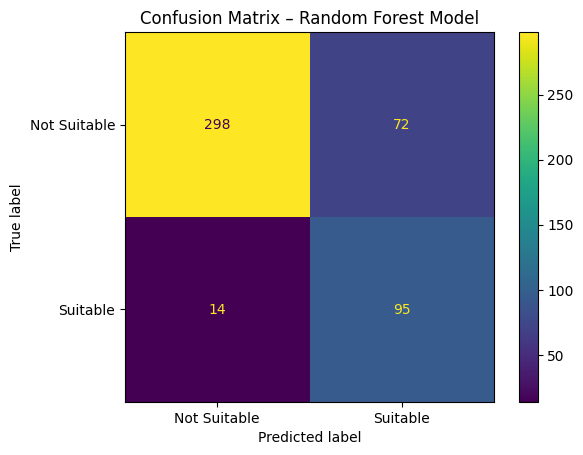

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Not Suitable', 'Suitable']
)

disp.plot()
plt.title("Confusion Matrix – Random Forest Model")
plt.show()
